## Libaries

In [1]:
# Main libraries installation
!pip install geopandas requests contextily geopy faker > nul

In [2]:
# Import necessary libraries
import random
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd      # For working with geospatial data
import pandas as pd          # For data manipulation and analysis
import os                    # For operating system-related functionality
import io                    # For input/output operations
import contextily as cx      # For basemaps and context tiles
import matplotlib.pyplot as plt  # For creating visualizations
from rasterio.crs import CRS  # For handling coordinate reference systems
from math import sin, asin, fmod, pi
import numpy as np
import plotly.express as px  # Library for creating interactive visualizations
from faker import Faker
import string
import plotly.io as pio  # Library for handling Plotly I/O
from IPython.display import Image  # Library for displaying images in IPython environment

# Set maximum display columns for pandas
pd.options.display.max_columns = None

## Data Ingestion

In [3]:
def generate_user_code():
    # Generate a random user code consisting of letters and digits
    characters = list(string.ascii_letters + string.digits)
    random.shuffle(characters)
    return ''.join(characters[:10])

def generate_city_points_mexico(quantity):
    # Define latitude and longitude boundaries for Mexico City
    latitude_min, latitude_max = 19.0, 19.6
    longitude_min, longitude_max = -99.4, -98.9
    points = []

    for _ in range(quantity):
        # Generate random coordinates within the specified boundaries
        latitude = round(random.uniform(latitude_min, latitude_max), 5)
        longitude = round(random.uniform(longitude_min, longitude_max), 5)
        
        # Generate a random User Code
        user_code = generate_user_code()
        
        points.append((latitude, longitude, user_code))

    return points

# Generate 1500 points in Mexico City
city_points_mexico = generate_city_points_mexico(750)

# Create a DataFrame with points and User Codes
columns = ['Latitude', 'Longitude', 'User Code']
df = pd.DataFrame(city_points_mexico, columns=columns)

df.head()

,Latitude,Longitude,User Code
0,19.45268,-99.19848,60uw9S5EOJ
1,19.40506,-99.15403,DjUbWtzFAE
2,19.10840,-98.90971,dC5Ytu4gR2
3,19.31309,-99.37630,ErbDoaQpqY
4,19.59630,-99.13569,q94EoU1yhi


## Data exploring

In [4]:
# Convert latitude and longitude from Cartesian coordinates to geographical coordinates

# Convert latitude using arcsine function
df['lat'] = df['Latitude'].apply(lambda lat: asin(sin((lat/180.0)*pi)) * (180.0/pi))

# Convert longitude using modulo and subtraction
df['lon'] = df['Longitude'].apply(lambda lon: fmod(lon - 180.0, 360.0) + 180.0)

In [5]:
# Combine the converted coordinates and transform them into a human-readable address

# Use the Nominatim geocoder with a specific user agent and timeout
locator = Nominatim(user_agent='my_app/0.1', timeout=76000)

# Combine latitude and longitude as a string for each row
df['lat_lon'] = df['lat'].astype(str) + ',' + df['lon'].astype(str)

# Apply reverse geocoding to convert coordinates into a human-readable address
df['location'] = df['lat_lon'].apply(lambda lat_lon: locator.reverse(lat_lon, language='en'))

In [7]:
# Display the first few rows of the DataFrame
df.head()

,Latitude,Longitude,User Code,lat,lon,lat_lon,location
0,19.45268,-99.19848,60uw9S5EOJ,19.45268,-99.19848,"19.45268,-99.19848000000002","(Unidad de Medicina Familiar 17 Legaria, Calza..."
1,19.40506,-99.15403,DjUbWtzFAE,19.40506,-99.15403,"19.40506,-99.15403000000003","(Panteón Frances, Avenida Cuauhtémoc, Buenos A..."
2,19.10840,-98.90971,dC5Ytu4gR2,19.10840,-98.90971,"19.1084,-98.90971000000002","(Juchitepec, Mexico, (19.100827, -98.8788452))"
3,19.31309,-99.37630,ErbDoaQpqY,19.31309,-99.37630,"19.31309,-99.37630000000001","(Avenida 16 de Septiembre, El Tejocote, La Cañ..."
4,19.59630,-99.13569,q94EoU1yhi,19.59630,-99.13569,"19.5963,-99.13569000000001","(Ampliación San Mateo, Tultitlán, 54948, Mexic..."


In [8]:
# Extract the 'address' field from the reverse geocoded location information and assign it to a new column 'dirección'
df['dirección'] = df['location'].apply(lambda loc: loc.raw['address'])

In [9]:
# Use the JSON with addresses and convert each attribute into a column

# Street name
df['calle'] = df['dirección'].apply(lambda addr: addr.get('road', np.nan))

# House number
df['numero_casa'] = df['dirección'].apply(lambda addr: addr.get('house_number', np.nan))

# Postal code
df['codigo_postal'] = df['dirección'].apply(lambda addr: addr.get('postcode', np.nan))

# Amenity (e.g., park, school, hospital)
df['amenity'] = df['dirección'].apply(lambda addr: addr.get('amenity', np.nan))

# Neighborhood
df['vecindario'] = df['dirección'].apply(lambda addr: addr.get('neighbourhood', np.nan))

# Suburb
df['suburbio'] = df['dirección'].apply(lambda addr: addr.get('suburb', np.nan))

# Man-made structure
df['estructura'] = df['dirección'].apply(lambda addr: addr.get('man_made', np.nan))

# Railway
df['vias_ferreas'] = df['dirección'].apply(lambda addr: addr.get('railway', np.nan))

# Highway
df['autopista'] = df['dirección'].apply(lambda addr: addr.get('highway', np.nan))

# Hamlet
df['aldea'] = df['dirección'].apply(lambda addr: addr.get('hamlet', np.nan))

# Village
df['villa'] = df['dirección'].apply(lambda addr: addr.get('village', np.nan))

# Town
df['poblado'] = df['dirección'].apply(lambda addr: addr.get('town', np.nan))

# Isolated dwelling
df['vivienda_aislada'] = df['dirección'].apply(lambda addr: addr.get('isolated_dwelling', np.nan))

# Quarter (asentamiento)
df['asentamiento'] = df['dirección'].apply(lambda addr: addr.get('quarter', np.nan))

# Residential area
df['zona_residencial'] = df['dirección'].apply(lambda addr: addr.get('residential', np.nan))

# Municipality
df['municipio'] = df['dirección'].apply(lambda addr: addr.get('municipality', np.nan))

# City
df['ciudad'] = df['dirección'].apply(lambda addr: addr.get('city', np.nan))

# City district
df['distrito'] = df['dirección'].apply(lambda addr: addr.get('city_district', np.nan))

# Province
df['provincia'] = df['dirección'].apply(lambda addr: addr.get('province', np.nan))

# Region
df['region'] = df['dirección'].apply(lambda addr: addr.get('region', np.nan))

# County
df['condado'] = df['dirección'].apply(lambda addr: addr.get('county', np.nan))

# State
df['estado'] = df['dirección'].apply(lambda addr: addr.get('state', np.nan))

# State district
df['distrito_estatal'] = df['dirección'].apply(lambda addr: addr.get('state_district', np.nan))

# Country
df['pais'] = df['dirección'].apply(lambda addr: addr.get('country', np.nan))

# Country code
df['codigo_pais'] = df['dirección'].apply(lambda addr: addr.get('country_code', np.nan))

# ISO3166-2-lvl4 code for country
df['pais_iso'] = df['dirección'].apply(lambda addr: addr.get('ISO3166-2-lvl4', np.nan))

# ISO3166-2-lvl15 code for sub-district
df['subdistrito_iso'] = df['dirección'].apply(lambda addr: addr.get('ISO3166-2-lvl15', np.nan))

# Tourism information
df['info_turistica'] = df['dirección'].apply(lambda addr: addr.get('tourism', np.nan))

# Building information
df['info_edilicia'] = df['dirección'].apply(lambda addr: addr.get('building', np.nan))

# Office information
df['info_oficina'] = df['dirección'].apply(lambda addr: addr.get('office', np.nan))

# Shop information
df['info_tienda'] = df['dirección'].apply(lambda addr: addr.get('shop', np.nan))

# Industrial information
df['info_industrial'] = df['dirección'].apply(lambda addr: addr.get('industrial', np.nan))

# Historic information
df['info_historica'] = df['dirección'].apply(lambda addr: addr.get('historic', np.nan))

In [10]:
# Drop the columns containing JSON-type data to facilitate export and visualization
df = df.drop(['location', 'dirección'], axis=1)

In [11]:
# Visualize the first 10 rows of the DataFrame with the generated columns
df.head(10)

,Latitude,Longitude,User Code,lat,lon,lat_lon,calle,numero_casa,codigo_postal,amenity,vecindario,suburbio,estructura,vias_ferreas,autopista,aldea,villa,poblado,vivienda_aislada,asentamiento,zona_residencial,municipio,ciudad,distrito,provincia,region,condado,estado,distrito_estatal,pais,codigo_pais,pais_iso,subdistrito_iso,info_turistica,info_edilicia,info_oficina,info_tienda,info_industrial,info_historica
0,19.45268,-99.19848,60uw9S5EOJ,19.45268,-99.19848,"19.45268,-99.19848000000002",Calzada Legaría,NaN,11260,Unidad de Medicina Familiar 17 Legaria,Colonia Deportiva Pensil,Miguel Hidalgo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Santa Fe,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,mx,MX-CMX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19.40506,-99.15403,DjUbWtzFAE,19.40506,-99.15403,"19.40506,-99.15403000000003",Avenida Cuauhtémoc,NaN,06780,NaN,Buenos Aires,Cuauhtémoc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mexico City,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,mx,MX-CMX,NaN,NaN,NaN,NaN,NaN,NaN,Panteón Frances
2,19.10840,-98.90971,dC5Ytu4gR2,19.10840,-98.90971,"19.1084,-98.90971000000002",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Juchitepec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Juchitepec,NaN,NaN,Mexico,mx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19.31309,-99.37630,ErbDoaQpqY,19.31309,-99.37630,"19.31309,-99.37630000000001",Avenida 16 de Septiembre,NaN,52798,NaN,El Tejocote,NaN,NaN,NaN,NaN,La Cañada,NaN,NaN,NaN,NaN,NaN,NaN,Huixquilucan de Degollado,NaN,NaN,NaN,Huixquilucan,NaN,NaN,Mexico,mx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.59630,-99.13569,q94EoU1yhi,19.59630,-99.13569,"19.5963,-99.13569000000001",NaN,NaN,54948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ampliación San Mateo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tultitlán,NaN,NaN,Mexico,mx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,19.46803,-99.09157,jhRso7x0BZ,19.46803,-99.09157,"19.46803,-99.09156999999999",Calle Puerto Savona,NaN,07940,NaN,Colonia Ejidos San Juan de Aragón 1a. Sección,Gustavo A. Madero,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mexico City,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,mx,MX-CMX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,19.49122,-99.31847,xVmLNoJp51,19.49122,-99.31847,"19.49122,-99.31846999999999",NaN,NaN,53126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jardines del Ojo de Agua,NaN,NaN,NaN,NaN,NaN,Naucalpan de Juárez,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,mx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,19.51584,-99.13745,d9ybzLwx4j,19.51584,-99.13745,"19.51584,-99.13745",Calle Plan de San Luis,NaN,07320,NaN,Colonia San Bernardino Ticomán I,Gustavo A. Madero,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mexico City,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,mx,MX-CMX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19.27286,-99.29138,ebx0SFOZMC,19.27286,-99.29138,"19.27286,-99.29138",Camino a los Dinamos de Contreras,NaN,01864,NaN,NaN,Álvaro Obregón,Cruz De Coconetla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Santa Fe,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,mx,MX-CMX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,19.44171,-99.36191,Uw2AauTXV9,19.44171,-99.36191,"19.44171,-99.36190999999997",NaN,NaN,53650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,San José Tejamanil,NaN,NaN,NaN,NaN,NaN,Naucalpan de Juárez,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,mx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Calculate the percentage of completeness for each column
num_rows = len(df)

for col in df.columns:
    # Count the number of non-null values in the column
    num_non_null = df[col].notnull().sum()
    
    # Calculate the completeness percentage
    completeness_pct = num_non_null / num_rows * 100
    
    # Print the completeness percentage for each column
    print(f"Completeness of {col}: {completeness_pct:.2f}%")

Completeness of Latitude: 100.00%
Completeness of Longitude: 100.00%
Completeness of User Code: 100.00%
Completeness of lat: 100.00%
Completeness of lon: 100.00%
Completeness of lat_lon: 100.00%
Completeness of calle: 52.40%
Completeness of numero_casa: 3.60%
Completeness of codigo_postal: 90.67%
Completeness of amenity: 1.87%
Completeness of vecindario: 30.93%
Completeness of suburbio: 30.67%
Completeness of estructura: 0.40%
Completeness of vias_ferreas: 0.00%
Completeness of autopista: 0.00%
Completeness of aldea: 2.40%
Completeness of villa: 19.33%
Completeness of poblado: 19.60%
Completeness of vivienda_aislada: 0.00%
Completeness of asentamiento: 2.53%
Completeness of zona_residencial: 1.33%
Completeness of municipio: 0.00%
Completeness of ciudad: 57.60%
Completeness of distrito: 1.47%
Completeness of provincia: 0.00%
Completeness of region: 0.00%
Completeness of condado: 45.33%
Completeness of estado: 22.00%
Completeness of distrito_estatal: 0.00%
Completeness of pais: 100.00%
C

## Data Visualization

In [18]:
# Create a map using Plotly Express with larger point sizes
fig = px.scatter_mapbox(df, 
                        lat=df.lat, 
                        lon=df.lon,
                        color='User Code',
                        color_continuous_scale='blues',
                        mapbox_style='dark',
                        zoom=12,
                        size_max=10)

# Update the map layout
fig.update_layout(mapbox_style="open-street-map")  # Set the map style to open street map
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})  # Adjust layout margins

# Display the map
fig.show()

In [19]:
# Assuming 'fig' is your Plotly figure
pio.write_html(fig, 'data/reverse.html')

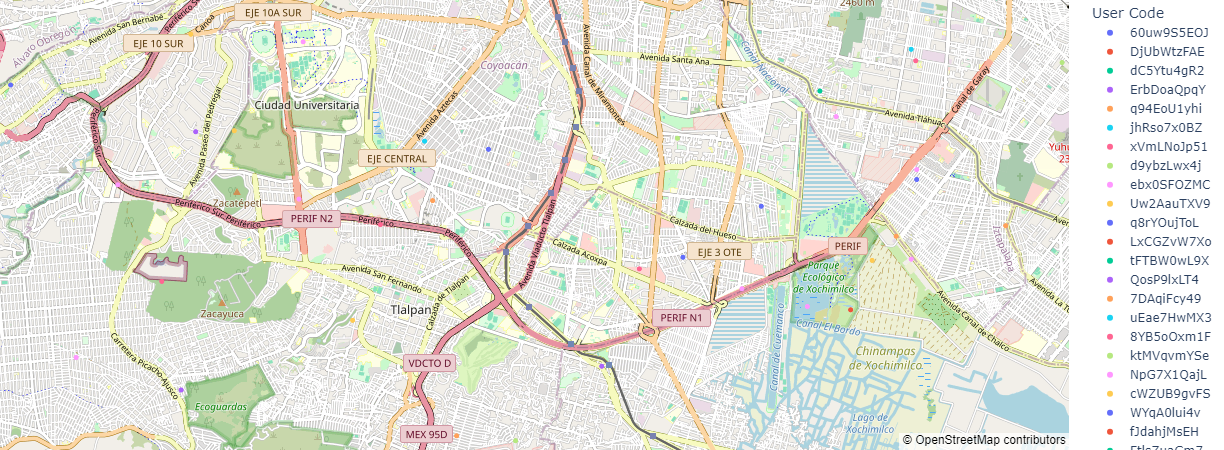

In [20]:
# Path to your PNG file
ruta_archivo_png = 'data/reverse.png'  # Replace with the correct path

# Display the image in the notebook
Image(filename=ruta_archivo_png)